In [114]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import KFold
import tensorflow as tf

# Set random seed
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

In [115]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE = 128

# Load the data
train_df = pd.read_csv(f"{ROOT}/train.csv")
test_df = pd.read_csv(f"{ROOT}/test.csv")
sample_submission = pd.read_csv(f"{ROOT}/sample_submission.csv")

# Remove duplicates
train_df.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])

# Parse `Patient_Week` from the sample submission
sample_submission['Patient'] = sample_submission['Patient_Week'].apply(lambda x: x.split('_')[0])
sample_submission['Weeks'] = sample_submission['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sample_submission = sample_submission[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]

# Combine all datasets
train_df['WHERE'] = 'train'
test_df['WHERE'] = 'val'
sample_submission['WHERE'] = 'test'
data = pd.concat([train_df, test_df, sample_submission], ignore_index=True)

# Add `min_week` for each patient
data['min_week'] = data['Weeks']
data.loc[data.WHERE == 'test', 'min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

# Add `base_FVC` for each patient at `min_week`
base_fvc = data.loc[data.Weeks == data.min_week, ['Patient', 'FVC']].drop_duplicates()
base_fvc.columns = ['Patient', 'min_FVC']
data = data.merge(base_fvc, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']

# Selected features
FEATURES = ['Age', 'Percent', 'Weeks', 'FVC', 'min_FVC', 'base_week']

# Split the data back
train_df = data[data.WHERE == 'train']
val_df = data[data.WHERE == 'val']
test_df = data[data.WHERE == 'test']

In [116]:
# Path to training DICOM files
train_dicom_path = f"{ROOT}/train"

# Directory to save preprocessed images
output_dir = './preprocessed_images'
os.makedirs(output_dir, exist_ok=True)

# Function to preprocess and save the middle slice of a patient's DICOMs
def preprocess_dicom(patient_id, dicom_path, output_dir):
    patient_folder = os.path.join(dicom_path, patient_id)
    dicom_files = sorted(os.listdir(patient_folder))
    dicom_slices = [pydicom.dcmread(os.path.join(patient_folder, f)) for f in dicom_files]
    
    # Get the middle slice
    middle_idx = len(dicom_slices) // 2
    middle_slice = dicom_slices[middle_idx].pixel_array.astype(float)
    
    # Normalize and resize
    normalized_slice = (middle_slice - middle_slice.min()) / (middle_slice.max() - middle_slice.min())
    resized_slice = np.array(Image.fromarray(normalized_slice).resize((224, 224)))
    
    # Save as PNG
    output_file = os.path.join(output_dir, f"{patient_id}.png")
    Image.fromarray((resized_slice * 255).astype(np.uint8)).save(output_file)
    return output_file

# Process and save images for all patients
image_paths = []
for patient_id in tqdm(train_df['Patient'].unique()):
    try:
        image_path = preprocess_dicom(patient_id, train_dicom_path, output_dir)
        image_paths.append({'Patient': patient_id, 'ImagePath': image_path})
    except Exception as e:
        print(f"Failed to process {patient_id}: {e}")

# Create a DataFrame with image paths
image_df = pd.DataFrame(image_paths)

# Merge image paths back into the training DataFrame
train_df = train_df.merge(image_df, on='Patient', how='left')

  3%|▎         | 5/176 [00:01<00:48,  3.51it/s]

Failed to process ID00011637202177653955184: Unable to decompress 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])' pixel data because all plugins are missing dependencies:
	gdcm - requires gdcm>=3.0.10
	pylibjpeg - requires pylibjpeg>=2.0 and pylibjpeg-libjpeg>=2.1


100%|██████████| 176/176 [01:31<00:00,  1.92it/s]


In [117]:
print(train_df[['Patient', 'ImagePath']].head())

                     Patient  \
0  ID00007637202177411956430   
1  ID00007637202177411956430   
2  ID00007637202177411956430   
3  ID00007637202177411956430   
4  ID00007637202177411956430   

                                             ImagePath  
0  ./preprocessed_images/ID00007637202177411956430.png  
1  ./preprocessed_images/ID00007637202177411956430.png  
2  ./preprocessed_images/ID00007637202177411956430.png  
3  ./preprocessed_images/ID00007637202177411956430.png  
4  ./preprocessed_images/ID00007637202177411956430.png  


In [118]:
threshold = 70

# Group by Patient and get the last follow-up (max Weeks) and corresponding Percent
label_df = (train_df.groupby('Patient', as_index=False)
            .apply(lambda x: x.loc[x['Weeks'].idxmax(), ['Patient', 'Percent']])
           )

# Add the binary label based on the threshold
label_df['Label'] = (label_df['Percent'] < threshold).astype(int)

# Merge the label back into the original DataFrame
train_df = train_df.merge(label_df[['Patient', 'Label']], on='Patient', how='left')

In [119]:
# Check for missing or invalid labels
print(train_df['Label'].value_counts(dropna=False))

# Identify rows with invalid or missing labels
invalid_labels = train_df[~train_df['Label'].isin([0, 1])]
if not invalid_labels.empty:
    print("Invalid or missing labels:")
    print(invalid_labels)
else:
    print("All labels are valid.")

Label
1    828
0    750
Name: count, dtype: int64
All labels are valid.


In [120]:
# Check for invalid entries in ImagePath
invalid_paths = train_df[~train_df['ImagePath'].apply(lambda x: isinstance(x, str))]
print(f"Number of invalid ImagePaths: {len(invalid_paths)}")
print(invalid_paths)

Number of invalid ImagePaths: 9
                      Patient  Weeks     FVC    Percent   Age   Sex  \
27  ID00011637202177653955184      6  3326.0  85.987590  72.0  Male   
28  ID00011637202177653955184      7  3419.0  88.391934  72.0  Male   
29  ID00011637202177653955184      9  3541.0  91.546019  72.0  Male   
30  ID00011637202177653955184     11  3502.0  90.537746  72.0  Male   
31  ID00011637202177653955184     13  3410.0  88.159255  72.0  Male   
32  ID00011637202177653955184     19  3477.0  89.891417  72.0  Male   
33  ID00011637202177653955184     32  3269.0  84.513961  72.0  Male   
34  ID00011637202177653955184     43  3346.0  86.504654  72.0  Male   
35  ID00011637202177653955184     58  3193.0  82.549121  72.0  Male   

   SmokingStatus  WHERE  Confidence Patient_Week  min_week  min_FVC  \
27     Ex-smoker  train         NaN          NaN       6.0   3326.0   
28     Ex-smoker  train         NaN          NaN       6.0   3326.0   
29     Ex-smoker  train         NaN         

In [121]:
# Drop rows with invalid ImagePath values
train_df = train_df[train_df['ImagePath'].apply(lambda x: isinstance(x, str))]

In [122]:
train_df['Patient'].nunique(), train_df['ImagePath'].nunique()

(175, 175)

# Final train df

In [123]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,ImagePath,Label
0,ID00007637202177411956430,-4,2315.0,58.253649,79.0,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,0.0,./preprocessed_images/ID00007637202177411956430.png,1
1,ID00007637202177411956430,5,2214.0,55.712129,79.0,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,9.0,./preprocessed_images/ID00007637202177411956430.png,1
2,ID00007637202177411956430,7,2061.0,51.862104,79.0,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,11.0,./preprocessed_images/ID00007637202177411956430.png,1
3,ID00007637202177411956430,9,2144.0,53.950679,79.0,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,13.0,./preprocessed_images/ID00007637202177411956430.png,1
4,ID00007637202177411956430,11,2069.0,52.063412,79.0,Male,Ex-smoker,train,NaN,NaN,-4.0,2315.0,15.0,./preprocessed_images/ID00007637202177411956430.png,1


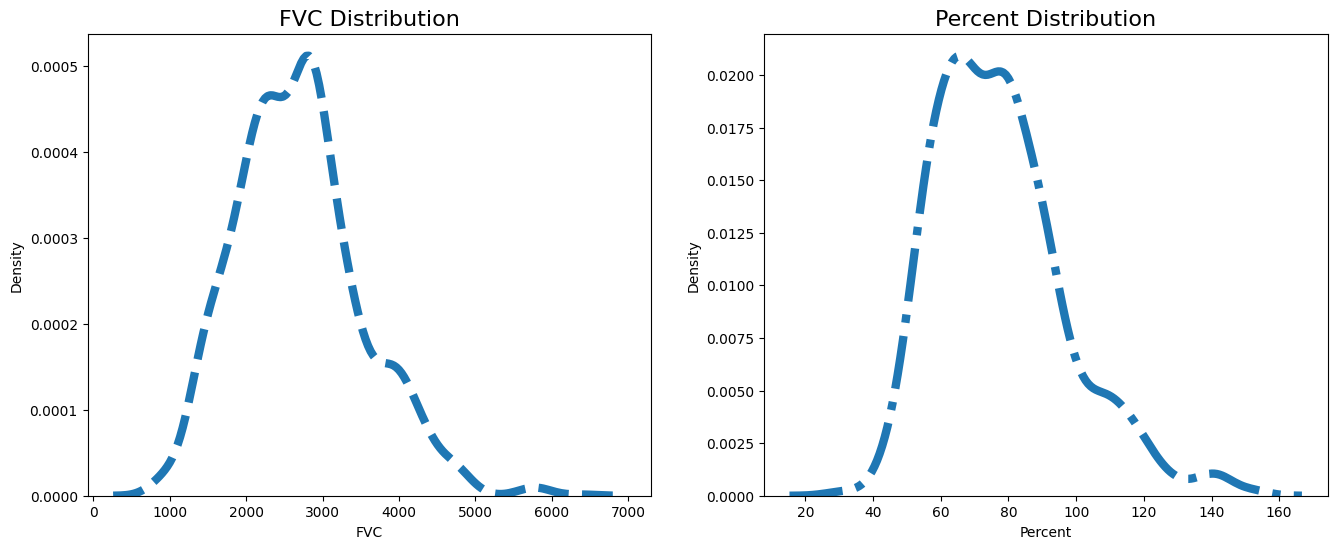

In [125]:
# Figure
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.distplot(train_df["FVC"], ax=ax1, hist=False, kde_kws=dict(lw=6, ls="--"))
b = sns.distplot(train_df["Percent"], ax=ax2, hist=False, kde_kws=dict(lw=6, ls="-."))

a.set_title("FVC Distribution", fontsize=16)
b.set_title("Percent Distribution", fontsize=16);

In [126]:
output_dir = './preprocessed_data'
os.makedirs(output_dir, exist_ok=True)
train_df.to_csv(os.path.join(output_dir, "train_data_forAI.csv"))

# Train FastAI model

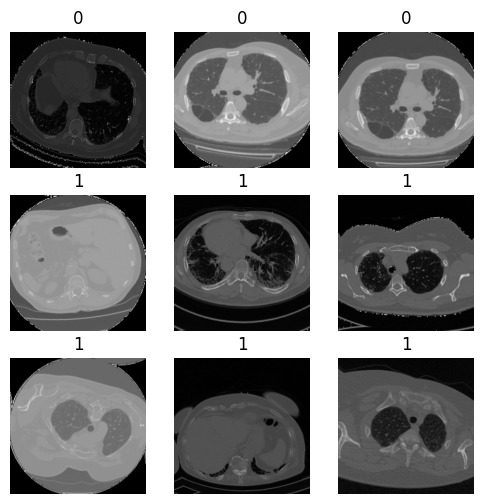

In [127]:
from fastai.vision.all import *

# Define a DataBlock for binary classification
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Input: Images, Output: Binary Labels
    get_x=ColReader('ImagePath'),       # Path to image
    get_y=ColReader('Label'),           # Binary target (0 or 1)
    splitter=RandomSplitter(0.2),       # 20% validation split
    item_tfms=Resize(224),              # Resize images to 224x224
    batch_tfms=aug_transforms()         # Apply data augmentation
)

# Create DataLoaders
data_loaders = data_block.dataloaders(train_df, bs=16)  # Batch size 16

# Visualize a batch
data_loaders.show_batch(max_n=9, figsize=(6, 6))

# OOF preds

In [130]:
# Filter train_df to only include one row per unique ImagePath
unique_train_df = train_df.drop_duplicates(subset='ImagePath').reset_index(drop=True)
print(f"Rows after filtering unique ImagePaths: {len(unique_train_df)}")

Rows after filtering unique ImagePaths: 175


In [131]:
def splitter(df):
    # Get train and validation indices
    train_idx = df.index[~df['is_valid']].tolist()
    valid_idx = df.index[df['is_valid']].tolist()
    return train_idx, valid_idx

## Multiple models

In [138]:
import warnings

# Suppress specific RuntimeWarnings
warnings.filterwarnings("ignore")

# Number of folds
n_splits = 15
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Backbones to train
backbones = [resnet34, squeezenet1_0, densenet121]

# Initialize dictionary to store OOF predictions for each model
oof_preds_all = {arch.__name__: np.zeros(len(unique_train_df)) for arch in backbones}

for arch in backbones:
    print(f"\nTraining with backbone: {arch.__name__}\n")

    # Prepare OOF predictions array for this model
    oof_preds = np.zeros(len(unique_train_df))

    for fold, (train_idx, val_idx) in enumerate(skf.split(unique_train_df, unique_train_df['Label'])):
        print(f"Fold {fold + 1}/{n_splits}")
        
        # Mark the validation set for the current fold
        unique_train_df['is_valid'] = False
        unique_train_df.loc[val_idx, 'is_valid'] = True
        
        # Create DataLoaders using the custom splitter
        data_block = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader('ImagePath'),
            get_y=ColReader('Label'),
            splitter=lambda df: splitter(df),  # Use the custom splitter
            item_tfms=Resize(224),
            batch_tfms=aug_transforms()
        )
        dls = data_block.dataloaders(unique_train_df, bs=8, num_workers=2)
        
        # Train the learner
        learn = vision_learner(dls, arch, metrics=F1Score())
        learn.fine_tune(3)
        
        # Get predictions for the validation fold
        preds, _ = learn.get_preds(dl=dls.valid)
        oof_preds[val_idx] = preds[:, 1].numpy()  # Store probabilities for positive class
    
    # Store OOF predictions for this architecture
    oof_preds_all[arch.__name__] = oof_preds


Training with backbone: resnet34

Fold 1/15


epoch,train_loss,valid_loss,f1_score,time
0,1.391243,1.344106,0.666667,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.197803,1.181748,0.800000,00:01
1,1.117647,1.138531,0.363636,00:01
2,1.041205,0.975145,0.615385,00:02


Fold 2/15


epoch,train_loss,valid_loss,f1_score,time
0,1.183381,1.621018,0.307692,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.096016,1.477030,0.166667,00:01
1,1.108429,0.937461,0.736842,00:01
2,1.009858,0.673853,0.823529,00:01


Fold 3/15


epoch,train_loss,valid_loss,f1_score,time
0,1.223813,1.136297,0.666667,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.100710,1.971003,0.666667,00:01
1,1.072503,1.857065,0.222222,00:01
2,1.013769,1.734637,0.181818,00:02


Fold 4/15


epoch,train_loss,valid_loss,f1_score,time
0,1.335594,1.415307,0.666667,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.432542,1.275517,0.750000,00:01
1,1.103925,1.104749,0.444444,00:01
2,0.929392,1.279551,0.444444,00:02


Fold 5/15


epoch,train_loss,valid_loss,f1_score,time
0,1.425741,0.980873,0.600000,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.030812,0.861229,0.714286,00:02
1,1.196153,0.932900,0.833333,00:02
2,1.052111,0.709187,0.666667,00:02


Fold 6/15


epoch,train_loss,valid_loss,f1_score,time
0,1.235501,1.294612,0.250000,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.140434,1.525356,0.250000,00:01
1,1.206258,1.119044,0.444444,00:01
2,1.005478,1.145554,0.444444,00:02


Fold 7/15


epoch,train_loss,valid_loss,f1_score,time
0,1.270223,1.463023,0.666667,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.563477,1.311866,0.588235,00:01
1,1.375054,1.082870,0.625000,00:02
2,1.078531,0.676123,0.666667,00:01


Fold 8/15


epoch,train_loss,valid_loss,f1_score,time
0,1.648777,0.721948,0.500000,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.087237,1.428174,0.285714,00:01
1,1.081168,1.302592,0.250000,00:01
2,0.944594,1.082834,0.600000,00:01


Fold 9/15


epoch,train_loss,valid_loss,f1_score,time
0,1.090278,1.529270,0.400000,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.139406,1.026573,0.000000,00:02
1,1.105685,1.505977,0.666667,00:02
2,1.021490,1.985338,0.625000,00:01


Fold 10/15


epoch,train_loss,valid_loss,f1_score,time
0,1.414200,1.450267,0.500000,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.004331,0.971409,0.545455,00:01
1,1.054037,2.109384,0.461538,00:01
2,0.986411,1.502513,0.500000,00:01


Fold 11/15


epoch,train_loss,valid_loss,f1_score,time
0,1.196149,0.900292,0.769231,00:01


epoch,train_loss,valid_loss,f1_score,time
0,0.962026,1.361079,0.545455,00:01
1,0.965268,1.868854,0.000000,00:01
2,0.961281,1.763072,0.000000,00:01


Fold 12/15


epoch,train_loss,valid_loss,f1_score,time
0,1.389874,2.661977,0.571429,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.158600,1.249641,0.666667,00:01
1,1.113919,1.715266,0.200000,00:01
2,1.030792,1.766727,0.200000,00:01


Fold 13/15


epoch,train_loss,valid_loss,f1_score,time
0,1.231010,1.105060,0.666667,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.069606,1.231282,0.666667,00:02
1,0.953308,0.783268,0.600000,00:01
2,0.917156,0.849941,0.600000,00:01


Fold 14/15


epoch,train_loss,valid_loss,f1_score,time
0,1.355275,1.032277,0.571429,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.050541,1.168834,0.571429,00:01
1,0.964346,1.007776,0.250000,00:01
2,0.905013,0.951901,0.222222,00:01


Fold 15/15


epoch,train_loss,valid_loss,f1_score,time
0,1.234527,1.617783,0.363636,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.040227,1.039733,0.666667,00:01
1,1.015398,0.847286,0.750000,00:01
2,0.913581,0.874972,0.714286,00:01



Training with backbone: squeezenet1_0

Fold 1/15


epoch,train_loss,valid_loss,f1_score,time
0,1.315124,1.078556,0.363636,00:00


epoch,train_loss,valid_loss,f1_score,time
0,0.807402,1.422891,0.333333,00:01
1,0.825548,1.396707,0.571429,00:01
2,0.770636,1.520118,0.666667,00:01


Fold 2/15


epoch,train_loss,valid_loss,f1_score,time
0,1.510134,1.441217,0.533333,00:00


epoch,train_loss,valid_loss,f1_score,time
0,0.988292,1.686599,0.363636,00:01
1,1.004282,1.873418,0.307692,00:01
2,0.899168,1.716895,0.333333,00:01


Fold 3/15


epoch,train_loss,valid_loss,f1_score,time
0,1.043678,1.538017,0.500000,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.240503,1.040697,0.363636,00:01
1,1.077294,1.233280,0.714286,00:01
2,1.008113,1.298746,0.571429,00:01


Fold 4/15


epoch,train_loss,valid_loss,f1_score,time
0,1.274817,1.332740,0.533333,00:00


epoch,train_loss,valid_loss,f1_score,time
0,1.033554,0.984630,0.625000,00:01
1,1.033429,1.428393,0.545455,00:01
2,0.988978,1.248909,0.545455,00:01


Fold 5/15


epoch,train_loss,valid_loss,f1_score,time
0,1.093969,0.972846,0.400000,00:00


epoch,train_loss,valid_loss,f1_score,time
0,0.891383,0.741354,0.666667,00:01
1,1.015942,0.912905,0.615385,00:01
2,0.927756,1.133619,0.615385,00:01


Fold 6/15


epoch,train_loss,valid_loss,f1_score,time
0,1.206539,1.689762,0.533333,00:00


epoch,train_loss,valid_loss,f1_score,time
0,1.076481,0.847592,0.750000,00:01
1,1.092216,0.479577,0.800000,00:01
2,1.011787,0.420332,0.833333,00:01


Fold 7/15


epoch,train_loss,valid_loss,f1_score,time
0,1.453233,1.340036,0.200000,00:00


epoch,train_loss,valid_loss,f1_score,time
0,1.148229,0.862294,0.666667,00:01
1,1.155026,1.050787,0.571429,00:01
2,0.929643,0.998606,0.615385,00:01


Fold 8/15


epoch,train_loss,valid_loss,f1_score,time
0,1.269299,1.478595,0.571429,00:00


epoch,train_loss,valid_loss,f1_score,time
0,0.841024,1.036511,0.444444,00:01
1,1.008493,1.075996,0.500000,00:01
2,0.892862,1.308179,0.500000,00:01


Fold 9/15


epoch,train_loss,valid_loss,f1_score,time
0,1.354150,1.731822,0.500000,00:00


epoch,train_loss,valid_loss,f1_score,time
0,1.196508,0.762855,0.666667,00:01
1,1.212958,1.171811,0.363636,00:01
2,1.002445,1.117718,0.500000,00:01


Fold 10/15


epoch,train_loss,valid_loss,f1_score,time
0,1.361439,1.599817,0.615385,00:01


epoch,train_loss,valid_loss,f1_score,time
0,1.025153,2.182038,0.461538,00:01
1,0.887980,1.755761,0.571429,00:01
2,0.790083,1.370864,0.571429,00:01


Fold 11/15


epoch,train_loss,valid_loss,f1_score,time
0,1.204992,1.119693,0.769231,00:00


epoch,train_loss,valid_loss,f1_score,time
0,0.856037,1.034549,0.727273,00:01
1,0.897242,1.672156,0.363636,00:01
2,0.798957,1.728672,0.363636,00:01


Fold 12/15


epoch,train_loss,valid_loss,f1_score,time
0,1.369018,0.869240,0.714286,00:00


epoch,train_loss,valid_loss,f1_score,time
0,1.088352,0.711927,0.666667,00:01
1,0.899807,1.384022,0.428571,00:01
2,0.777139,1.288700,0.428571,00:01


Fold 13/15


epoch,train_loss,valid_loss,f1_score,time
0,1.320392,1.172123,0.600000,00:00


epoch,train_loss,valid_loss,f1_score,time
0,1.219520,0.872039,0.727273,00:01
1,1.086199,0.517724,0.800000,00:01
2,1.037568,0.417049,0.800000,00:01


Fold 14/15


epoch,train_loss,valid_loss,f1_score,time
0,1.330364,1.181540,0.750000,00:00


epoch,train_loss,valid_loss,f1_score,time
0,1.080360,0.794558,0.545455,00:01
1,1.049011,0.888498,0.600000,00:01
2,0.937016,0.825902,0.714286,00:01


Fold 15/15


epoch,train_loss,valid_loss,f1_score,time
0,1.481256,1.028016,0.750000,00:00


epoch,train_loss,valid_loss,f1_score,time
0,1.031054,1.369869,0.750000,00:01
1,1.032794,0.655531,0.857143,00:01
2,1.012072,0.646661,0.750000,00:01



Training with backbone: densenet121

Fold 1/15


epoch,train_loss,valid_loss,f1_score,time
0,1.529148,1.500853,0.500000,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.106943,0.928441,0.500000,00:03
1,1.083276,1.301612,0.615385,00:03
2,0.994186,1.214498,0.615385,00:03


Fold 2/15


epoch,train_loss,valid_loss,f1_score,time
0,1.407402,1.059517,0.625000,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.067350,1.138175,0.705882,00:03
1,0.961108,0.879530,0.625000,00:03
2,0.870749,0.934564,0.428571,00:03


Fold 3/15


epoch,train_loss,valid_loss,f1_score,time
0,1.428031,2.177944,0.200000,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.277311,1.583205,0.615385,00:03
1,1.206569,2.149023,0.200000,00:03
2,1.067294,1.622540,0.363636,00:03


Fold 4/15


epoch,train_loss,valid_loss,f1_score,time
0,1.388588,1.265845,0.571429,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.058453,1.460007,0.571429,00:03
1,1.173028,1.302402,0.500000,00:03
2,1.079599,1.495340,0.500000,00:03


Fold 5/15


epoch,train_loss,valid_loss,f1_score,time
0,1.358133,1.460974,0.444444,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.324284,1.302942,0.363636,00:03
1,1.248636,0.952309,0.666667,00:03
2,1.126151,0.988021,0.571429,00:03


Fold 6/15


epoch,train_loss,valid_loss,f1_score,time
0,1.410455,0.955476,0.714286,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.230293,0.826806,0.714286,00:03
1,1.067183,1.253342,0.500000,00:03
2,0.926765,0.935082,0.615385,00:03


Fold 7/15


epoch,train_loss,valid_loss,f1_score,time
0,1.321500,1.086252,0.615385,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.160546,1.050345,0.625000,00:03
1,0.971414,0.492902,0.800000,00:03
2,0.867485,0.506114,0.666667,00:03


Fold 8/15


epoch,train_loss,valid_loss,f1_score,time
0,1.300035,1.656757,0.571429,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.527264,1.302202,0.333333,00:03
1,1.320164,1.411200,0.625000,00:03
2,1.112217,1.028291,0.666667,00:03


Fold 9/15


epoch,train_loss,valid_loss,f1_score,time
0,1.491472,1.826000,0.625000,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.386545,1.276462,0.714286,00:03
1,1.239104,1.587985,0.615385,00:03
2,1.048122,1.768450,0.200000,00:03


Fold 10/15


epoch,train_loss,valid_loss,f1_score,time
0,1.558028,1.259113,0.625000,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.031850,1.226333,0.461538,00:03
1,1.086695,1.541497,0.500000,00:03
2,0.962762,1.578703,0.461538,00:03


Fold 11/15


epoch,train_loss,valid_loss,f1_score,time
0,1.425324,1.509021,0.363636,00:02


epoch,train_loss,valid_loss,f1_score,time
0,0.974006,1.025225,0.666667,00:03
1,0.950062,1.334107,0.545455,00:03
2,0.897862,1.689846,0.200000,00:03


Fold 12/15


epoch,train_loss,valid_loss,f1_score,time
0,1.558116,1.880814,0.750000,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.196470,1.013023,0.625000,00:03
1,1.069706,0.777984,0.500000,00:03
2,1.004116,0.806657,0.500000,00:03


Fold 13/15


epoch,train_loss,valid_loss,f1_score,time
0,1.515734,1.051371,0.800000,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.033396,0.789605,0.769231,00:03
1,1.122529,1.030572,0.500000,00:03
2,0.927076,1.047413,0.400000,00:03


Fold 14/15


epoch,train_loss,valid_loss,f1_score,time
0,1.665858,1.272276,0.222222,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.336114,0.563141,0.769231,00:03
1,1.071231,0.828535,0.666667,00:03
2,0.947922,0.553406,0.769231,00:03


Fold 15/15


epoch,train_loss,valid_loss,f1_score,time
0,1.315219,1.281089,0.615385,00:02


epoch,train_loss,valid_loss,f1_score,time
0,1.372817,0.906450,0.714286,00:03
1,1.280946,1.185023,0.666667,00:03
2,1.041932,0.858848,0.750000,00:03


# Merge preds with train metadata

In [139]:
# Add OOF predictions for each architecture to unique_train_df
for arch_name, preds in oof_preds_all.items():
    unique_train_df[f'OOF_{arch_name}'] = preds

# Save the updated DataFrame
unique_train_df.to_csv('unique_train_with_oof.csv', index=False)
print("Saved OOF predictions for all architectures in 'unique_train_with_oof.csv'")

Saved OOF predictions for all architectures in 'unique_train_with_oof.csv'


# Save predictions on train data and models

In [141]:
# Save learners for each architecture
for arch in backbones:
    learn.export(f'{arch.__name__}_model.pkl')
    print(f"Saved learner for {arch.__name__} as '{arch.__name__}_model.pkl'")

Saved learner for resnet34 as 'resnet34_model.pkl'
Saved learner for squeezenet1_0 as 'squeezenet1_0_model.pkl'
Saved learner for densenet121 as 'densenet121_model.pkl'


In [152]:
columns = ['Patient', 'ImagePath', 'Label', 'Age', 'Weeks', 'FVC', 'Sex', 'SmokingStatus', 'min_FVC', 'base_week']

In [154]:
final_train_df = train_df[columns].merge(unique_train_df[['Patient','OOF_resnet34',
       'OOF_squeezenet1_0', 'OOF_densenet121']], 
                                         on='Patient', 
                                         how='left')
final_train_df.to_csv('full_train_with_oof.csv', index=False)